# Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import kornia

## Load Bowl of Fruit Image

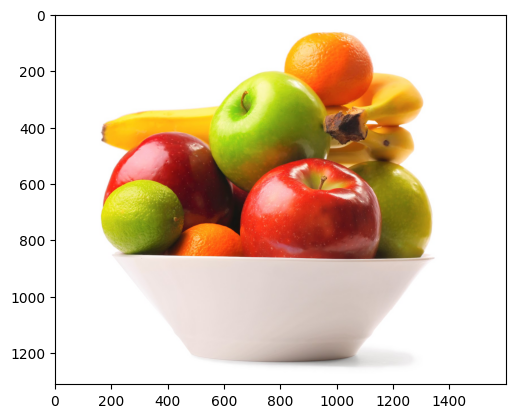

In [2]:
img = plt.imread('bowl-of-fruit.jpg')
plt.imshow(img)

## My Canny Function

In [3]:
from scipy import ndimage

def MyCanny(img, sd, gradiant_threshold):
    #convert image to BxCXWXH tensor
    tensor_img = torch.tensor(img, dtype=torch.float32)
    tensor_img = torch.unsqueeze(tensor_img, dim=0)
    tensor_img = torch.permute(tensor_img, (0, 3, 1, 2))

    #gray scale
    gray_img = kornia.color.rgb_to_grayscale(tensor_img)
    
    #Apply gaussian blur
    smooth_gray_img = kornia.filters.gaussian_blur2d(gray_img, (5, 5), sd)
    
    sobel_y = torch.tensor([[[[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]]]], dtype=torch.float32)
    sobel_x = torch.tensor([[[[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]]]], dtype=torch.float32)
    y_grads = torch.nn.functional.conv2d(smooth_gray_img, sobel_y, padding=1)[0, 0]
    x_grads = torch.nn.functional.conv2d(smooth_gray_img, sobel_x, padding=1)[0, 0]

    
    grad_magnitude = torch.sqrt(torch.pow(x_grads, 2) + torch.pow(y_grads, 2))
    grad_magnitude = grad_magnitude / grad_magnitude.max() * 255
    grad_direction = torch.atan2(y_grads, x_grads)
    
    #non maximum supression
    H, W = gray_img.size()[2], gray_img.size()[3]
    NMS_img = torch.zeros((H,W), dtype=torch.float32)
    degree_angles = 180 * grad_direction / torch.pi
    for i in range(1, H-1):
        for j in range(1, W-1):
            #0 and 180
            if (-180 <= degree_angles[i,j] < 157.5) or ( -22.5 <= degree_angles[i,j] <= 0) or (0 <= degree_angles[i,j] < 22.5) or (157.5 <= degree_angles[i,j] <= 180):
                right, left = grad_magnitude[i, j+1], grad_magnitude[i, j-1]
            #45
            elif (-157.5 <= degree_angles[i,j] < -112.5) or (22.5 <= degree_angles[i,j] < 67.5):
                right, left = grad_magnitude[i+1, j-1], grad_magnitude[i-1, j+1]
            #90
            elif(-112.5 <= degree_angles[i,j] < -67.5) or (67.5 <= degree_angles[i,j] < 112.5):
                right, left = grad_magnitude[i+1, j], grad_magnitude[i-1, j]
            #135
            elif (-67.5 <= degree_angles[i,j] < -22.5) or (112.5 <= degree_angles[i,j] < 157.5):
                right, left = grad_magnitude[i-1, j-1], grad_magnitude[i+1, j+1]
            
            if (grad_magnitude[i,j] < right) or (grad_magnitude[i,j] < left):
                NMS_img[i,j] = 0
            else:
                NMS_img[i,j] = grad_magnitude[i,j]
    #threshold
    i, j = torch.where(NMS_img <= gradiant_threshold)
    NMS_img[i, j] = 0
    return grad_magnitude, NMS_img

grad_mag, NMS_img = MyCanny(img, (150, 150), 5)

Here I plot Grad magnitude and Non-maximum supression results to compare.

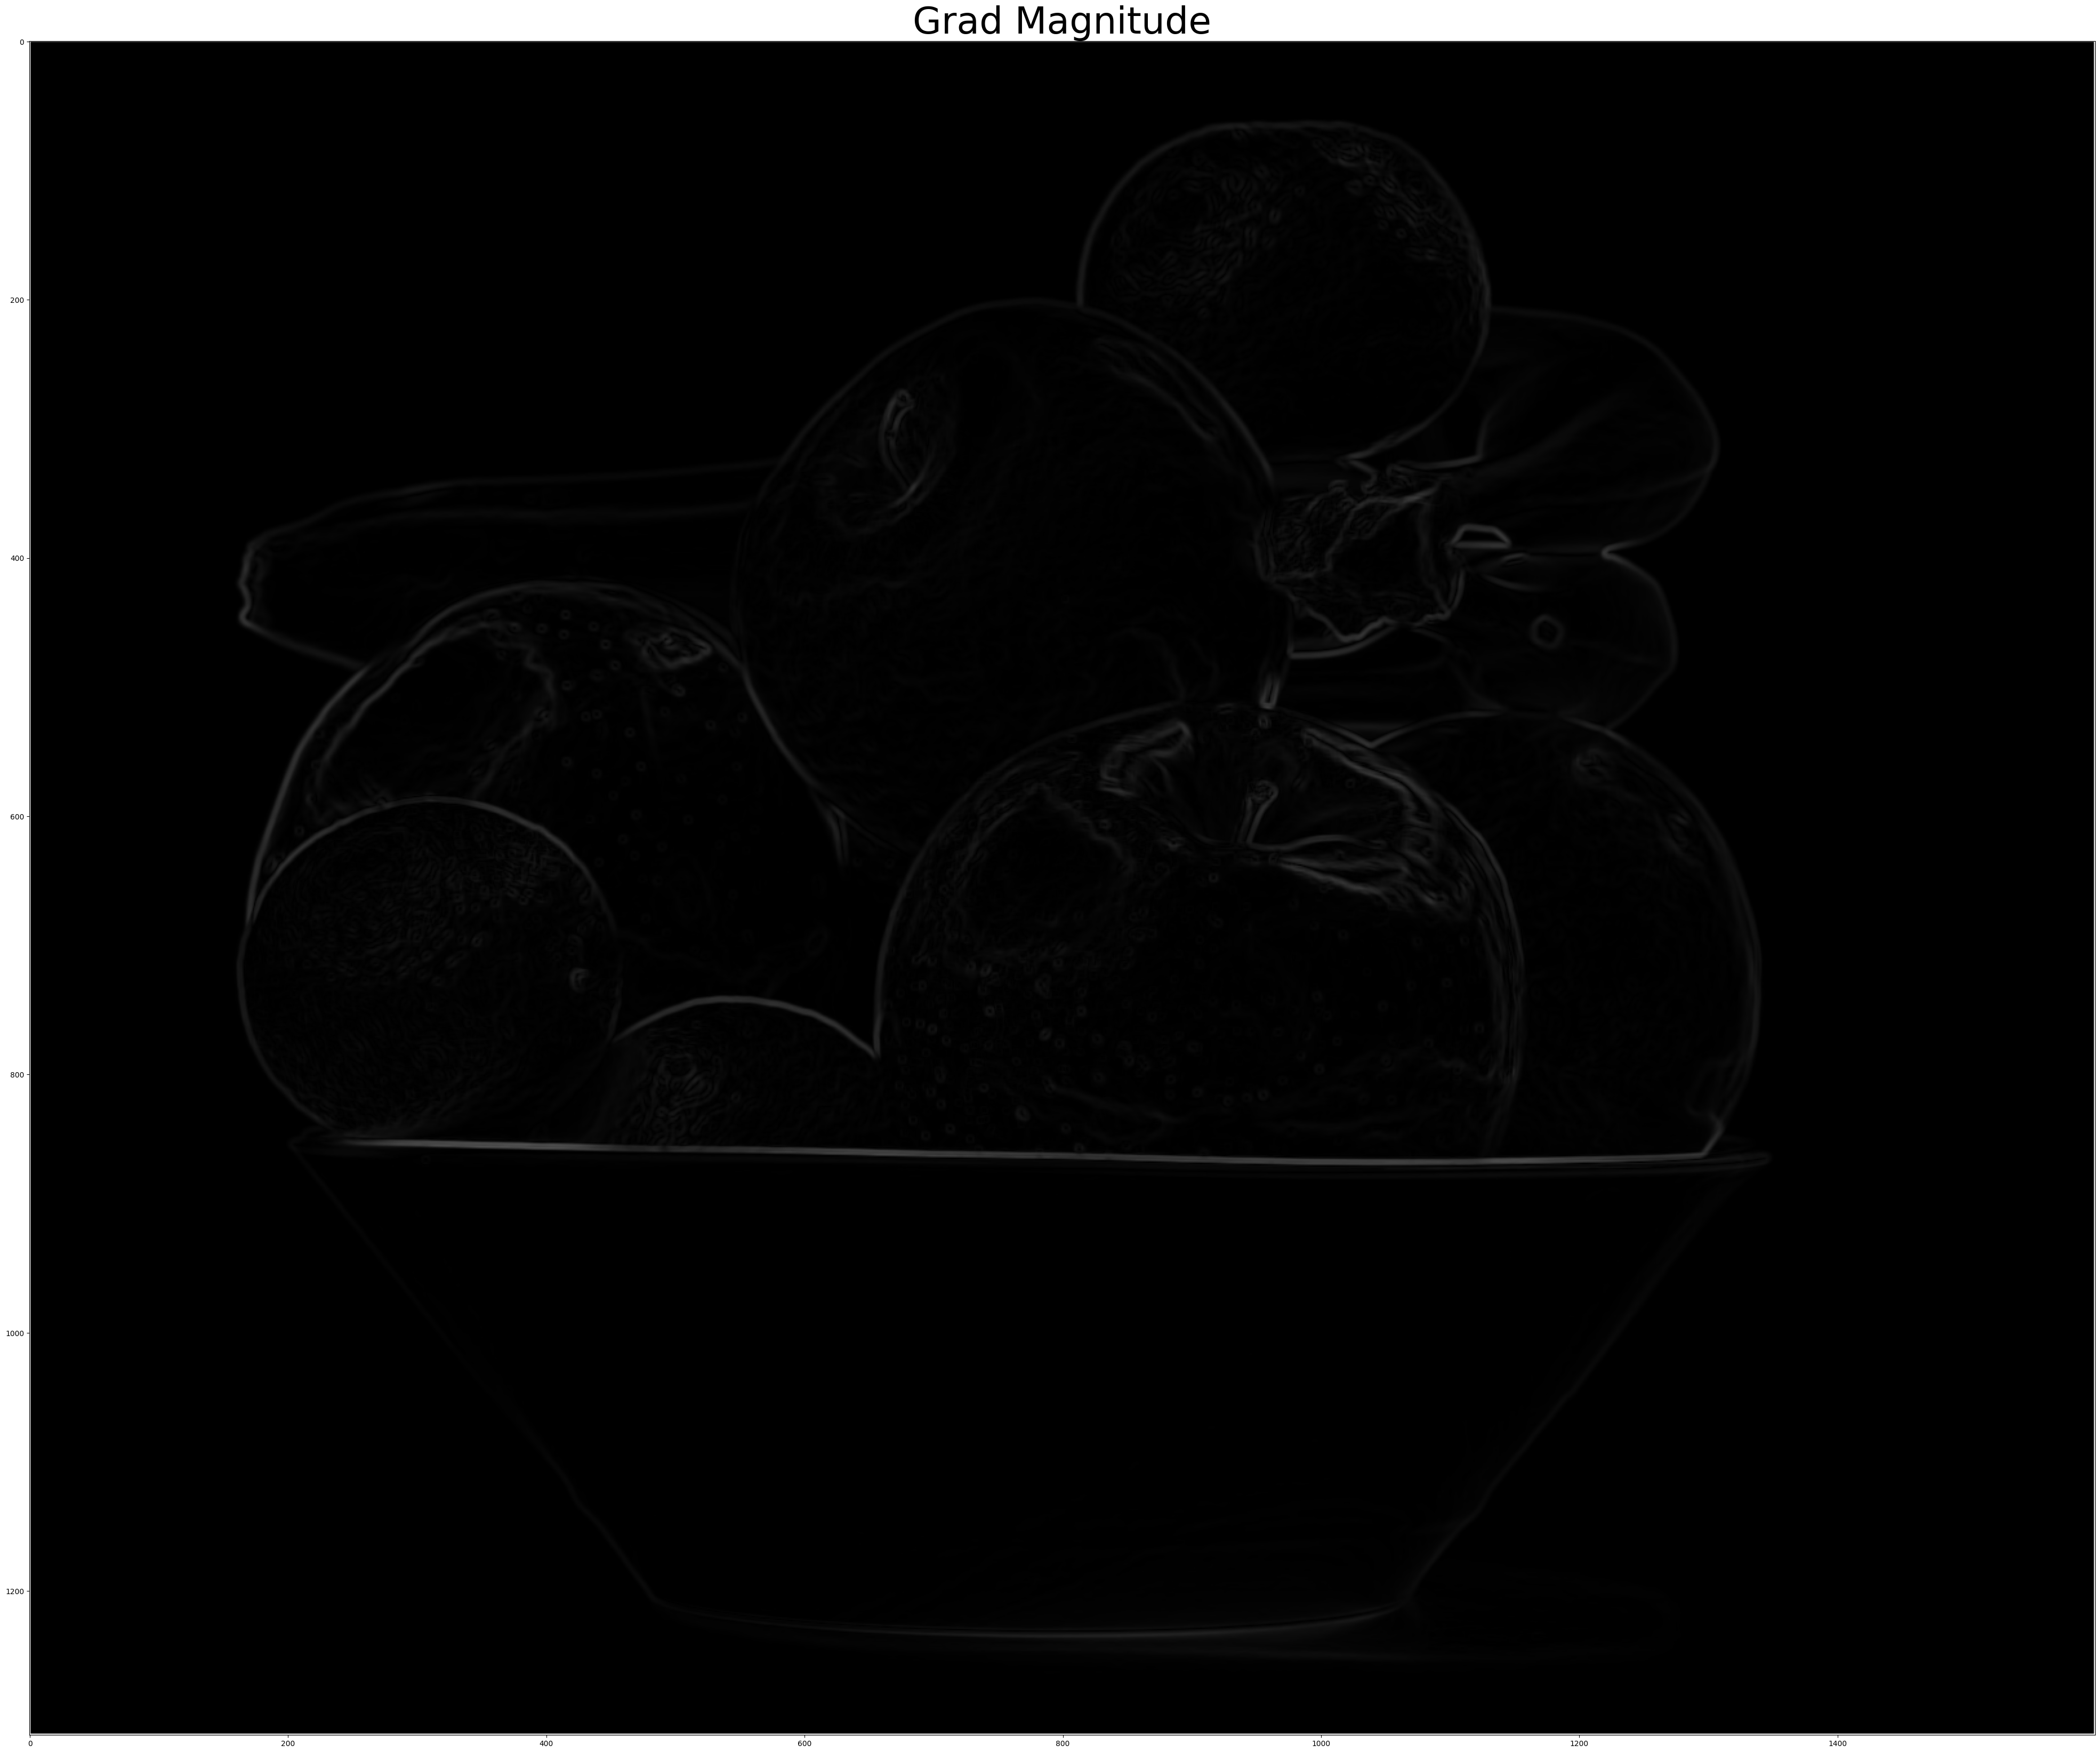

In [6]:
plt.figure(figsize=(50,50))
plt.title("Grad Magnitude", fontdict={'fontsize': 50})
plt.imshow(grad_mag, cmap="gray")

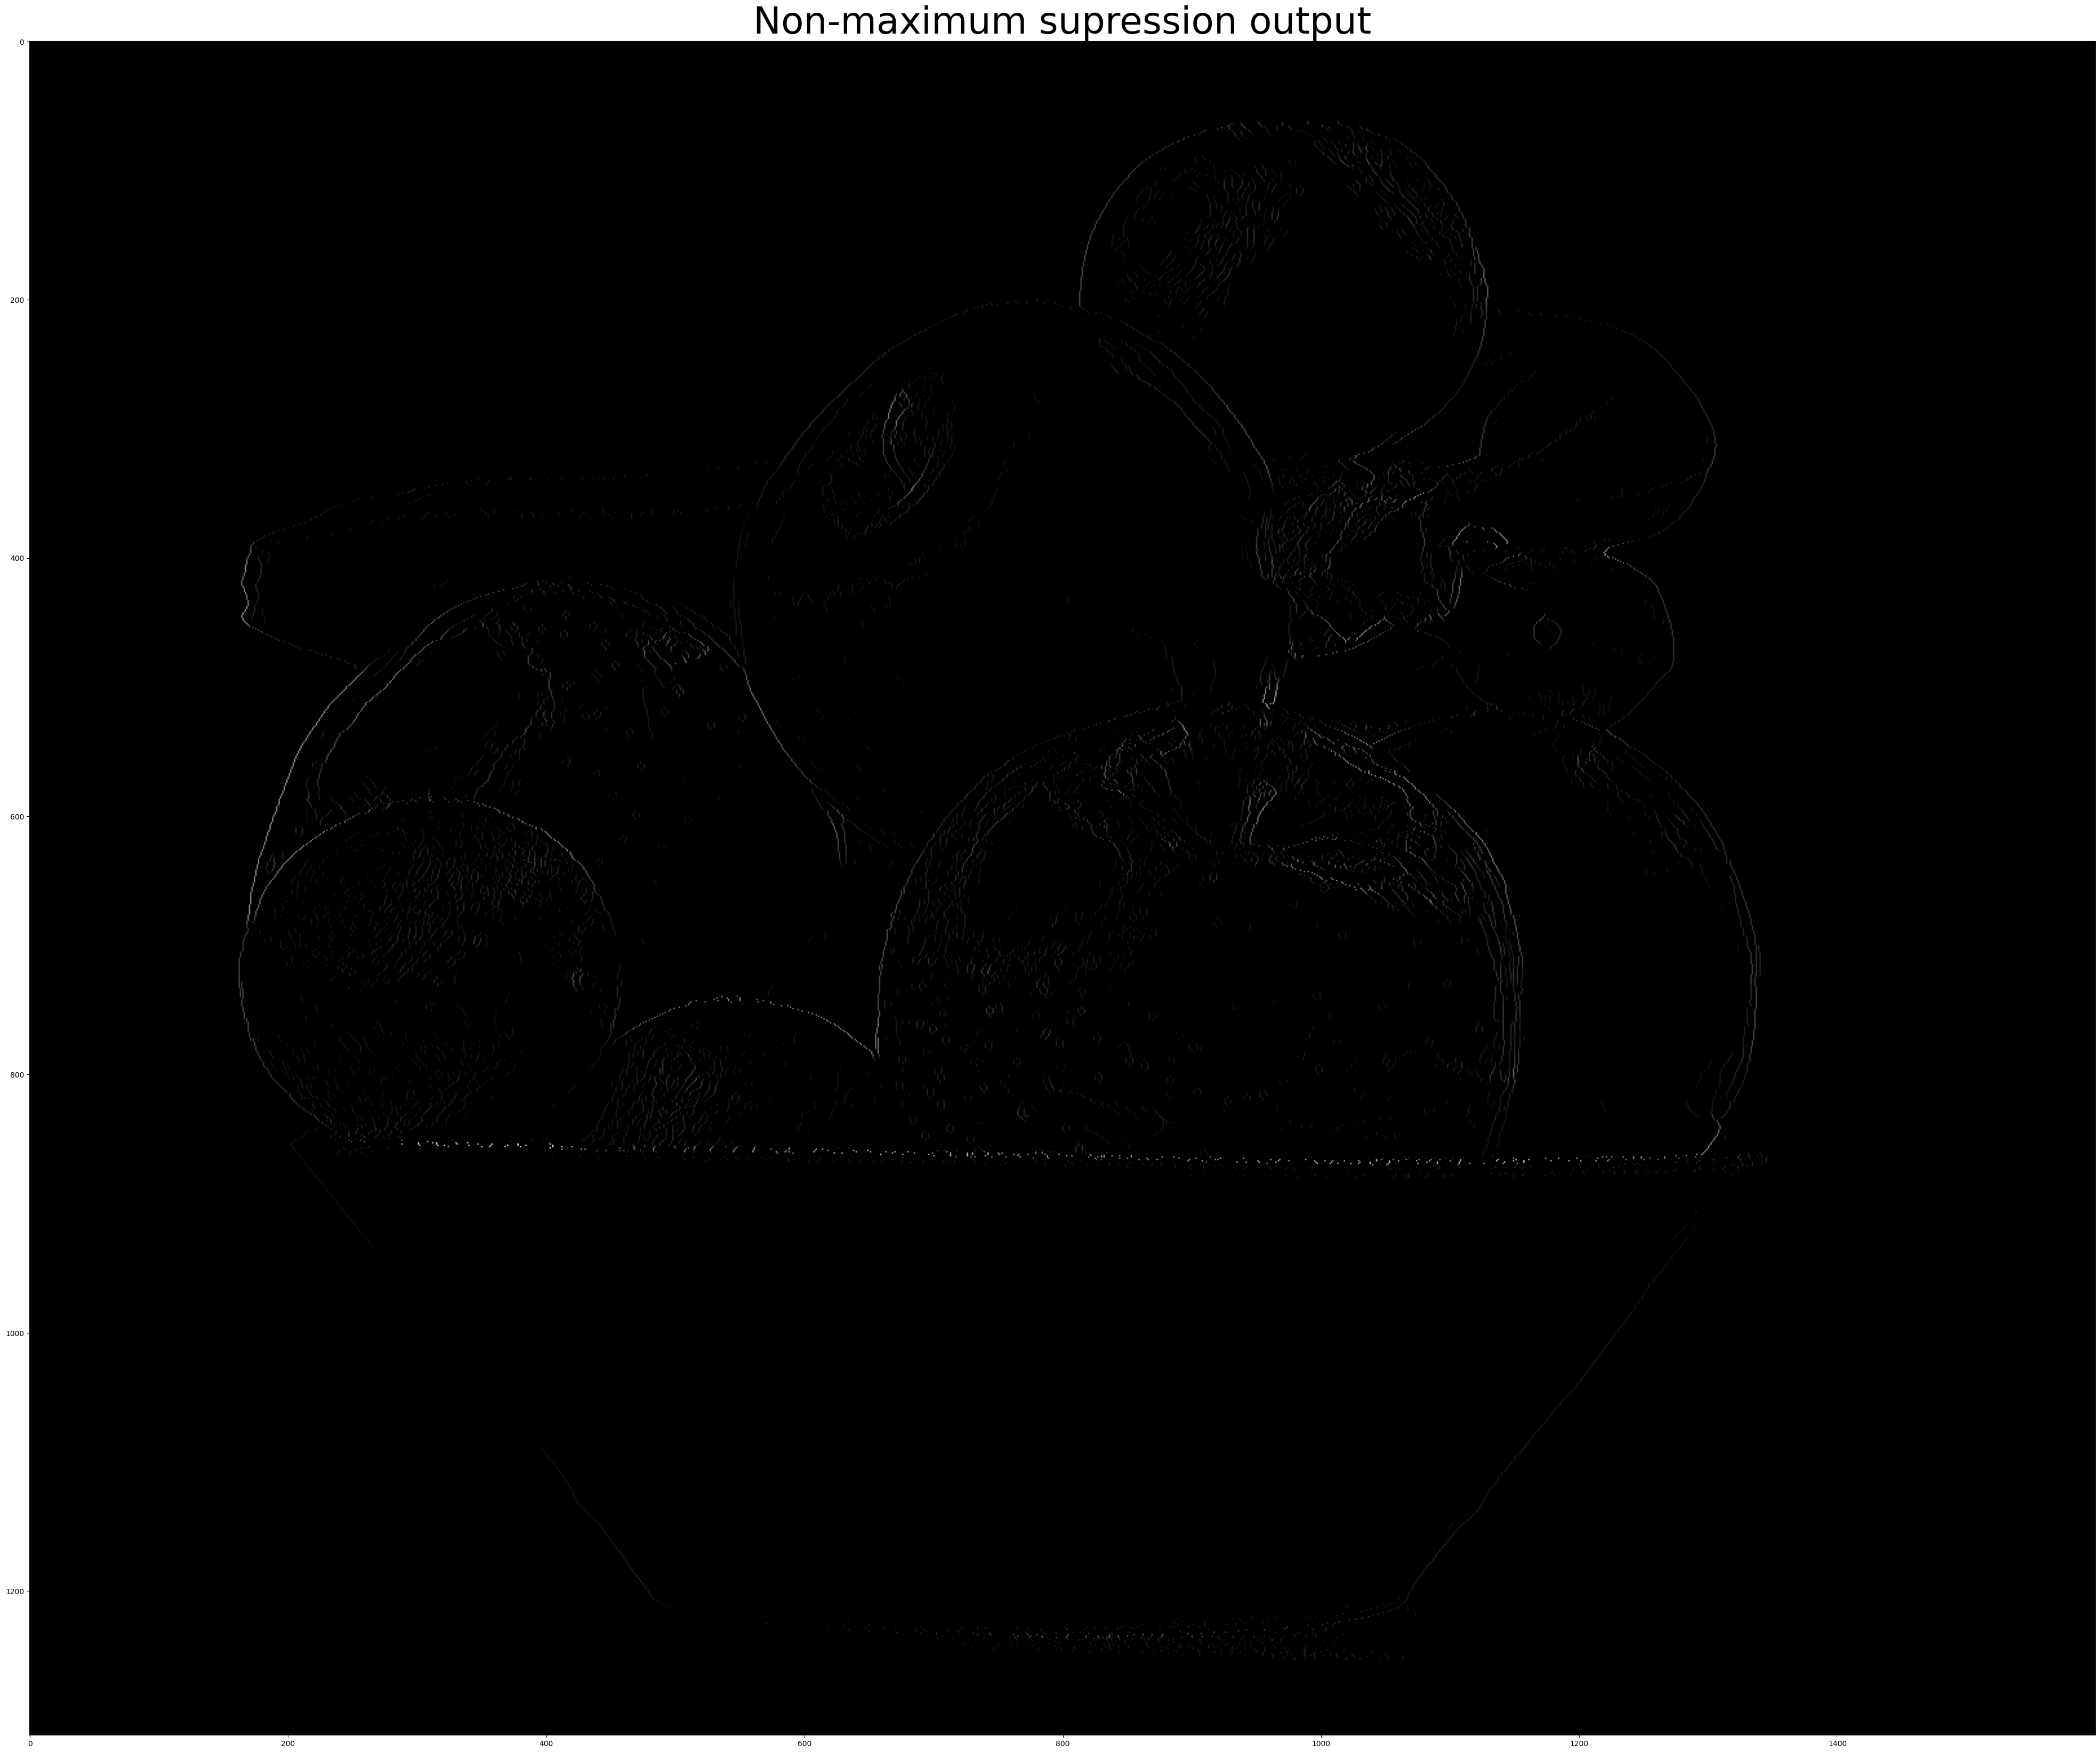

In [7]:
plt.figure(figsize=(50,50))
plt.title("Non-maximum supression output", fontdict={'fontsize': 50})
plt.imshow(NMS_img, cmap="gray")

## My Canny Full Function

In [53]:
def MyCannyFull(img, sd, thresh, low_threshold, high_threshold):
# def MyCannyFull(NMS_img, low_threshold, high_threshold):
    _, NMS_img = MyCanny(img, (sd, sd), thresh)
    hysteresis_img = NMS_img.clone()
    h, w = NMS_img.shape[0], NMS_img.shape[1]
    
    #hysteresis
    high_x, high_y = torch.where(NMS_img >= high_threshold)
    hysteresis_img[high_x, high_y] = 255
    queue_x, queue_y = high_x, high_y
    visit_pix = torch.zeros((h, w))
    visit_pix[queue_x, queue_y] = 1

    ##bfs
    neighbours = [-1, 0, 1]
    while queue_x.shape[0] != 0:
        current_pixel_x = queue_x[0]
        current_pixel_y = queue_y[0]
        
        queue_x = queue_x[1:]
        queue_y = queue_y[1:]
        for i in neighbours:
            for j in neighbours:
                if (current_pixel_x == 0 and i == -1) or (current_pixel_x == h-1 and i == 1) or (current_pixel_y == 0 and j == -1) or (current_pixel_y == w-1 and j == 1):
                    continue 
                if  visit_pix[current_pixel_x.item() + i, current_pixel_y.item() + j] == 0 and NMS_img[current_pixel_x.item() + i, current_pixel_y.item() + j] >= low_threshold:
                    hysteresis_img[current_pixel_x.item() + i, current_pixel_y.item() + j] = 255
                    queue_x = torch.cat((queue_x, current_pixel_x.unsqueeze(0) + i))
                    queue_y = torch.cat((queue_y, current_pixel_y.unsqueeze(0) + j))
                    visit_pix[current_pixel_x.item() + i, current_pixel_y.item() + j] = 1
    
    return NMS_img, hysteresis_img

_, hysteresis_img = MyCannyFull(img, 150, 5, 0.5, 10)

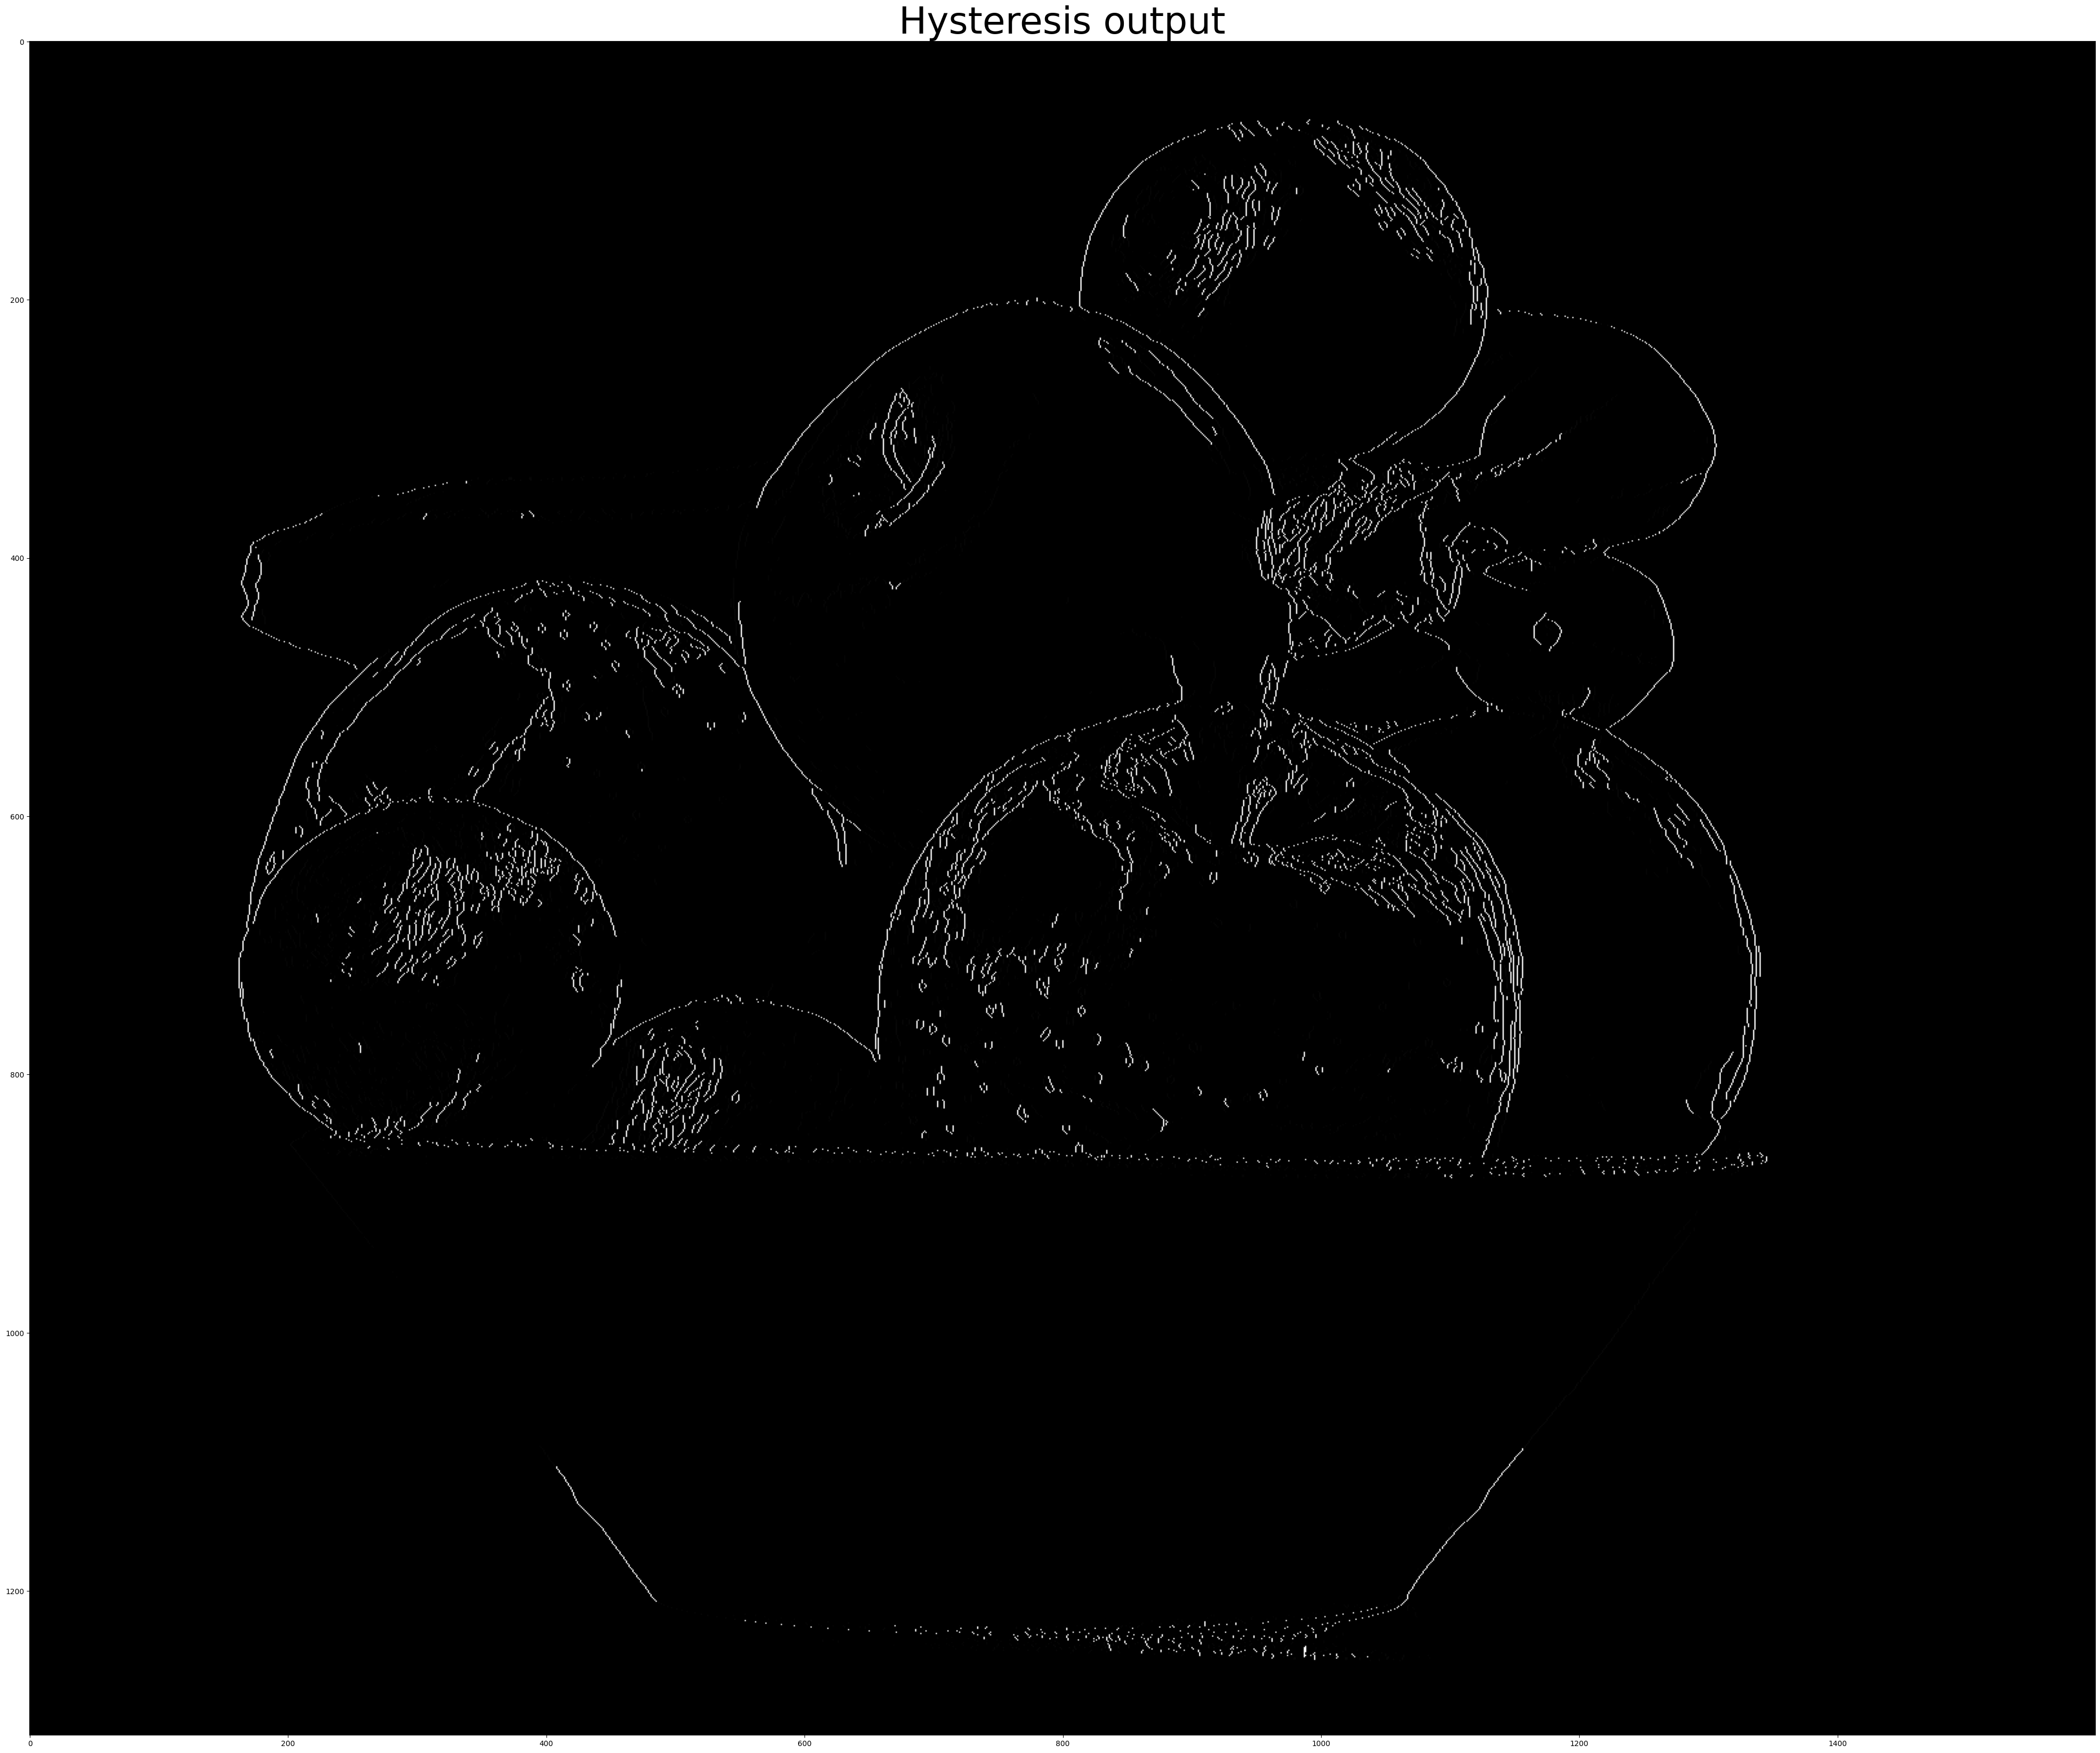

In [23]:
plt.figure(figsize=(50,50))
plt.title("Hysteresis output", fontdict={'fontsize': 50})
plt.imshow(hysteresis_img / 255, cmap="gray")

## Run My Canny Edge Detection on another image

In [24]:
from PIL import Image

save_img = Image.fromarray(np.uint8(hysteresis_img))
save_img = save_img.save('bowl-of-fruit_canny_edge.jpg')

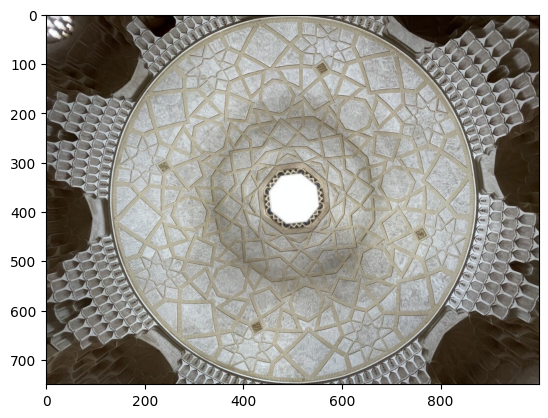

In [70]:
my_img = plt.imread('My_edge_detection.jpg')
plt.imshow(my_img)

In [67]:
NMS_my_img, hysteresis_my_img = MyCannyFull(my_img, 150, 10.5, 1.15, 10)

In [68]:
NMS_my_img.min(), NMS_my_img.max()

(tensor(0.), tensor(79.5345))

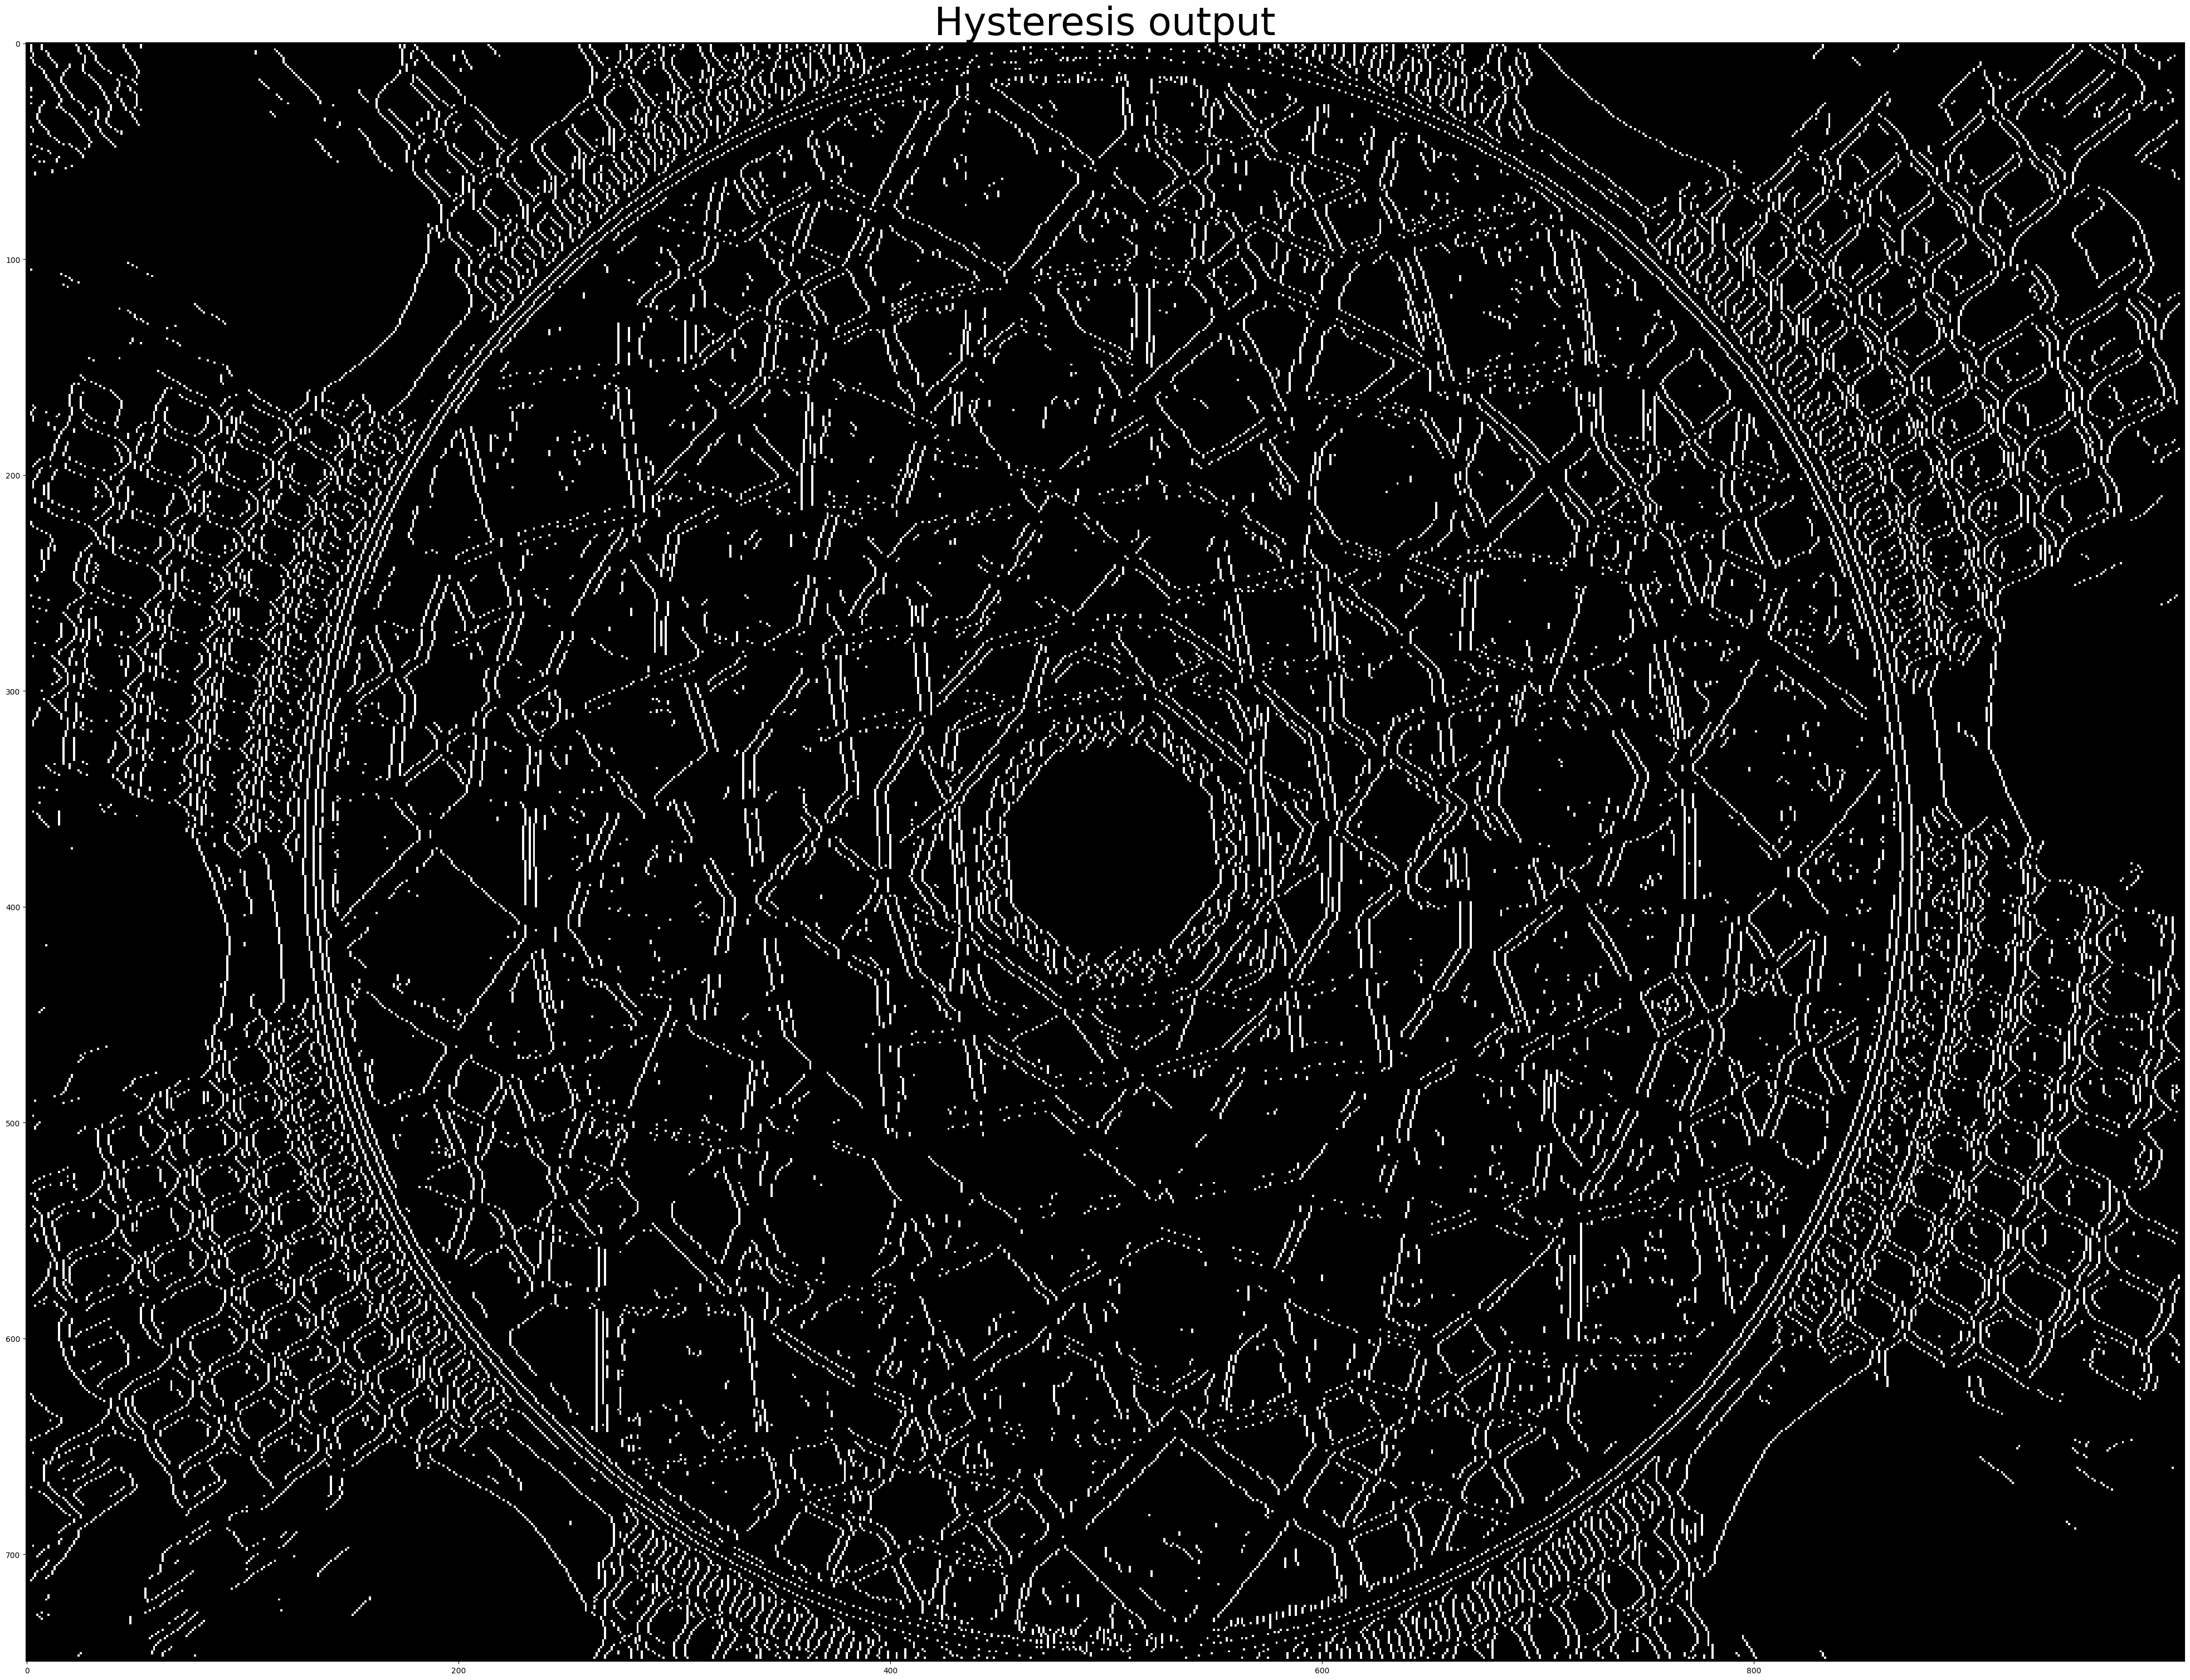

In [69]:
plt.figure(figsize=(50,50))
plt.title("Hysteresis output", fontdict={'fontsize': 50})
plt.imshow(hysteresis_my_img / 255, cmap="gray")

In [72]:
save_img = Image.fromarray(np.uint8(hysteresis_my_img))
save_img = save_img.save('My_edge_detection_response.jpg')